In [1]:
import numpy as np
import xarray as xr
import scipy.io as sio

import matplotlib.pyplot as plt

In [2]:
rootdir = '/raid1/chen423/serdp/archive/GRL2020/'

plotdir = rootdir + 'plots/'

In [3]:
# WRF in SERDP6km grids
infile = rootdir + 'data/HIST/stats/CAPE_mean.mat'
CAPEmean_HIST = sio.loadmat(infile)['CAPE_HIST_mean']
CAPEmean_fSST = sio.loadmat(infile)['CAPE_fSST_mean']

infile = rootdir + 'data/HIST/stats/CAPE_p85.mat'
CAPEp85_HIST = sio.loadmat(infile)['CAPE_HIST_p85']
CAPEp85_fSST = sio.loadmat(infile)['CAPE_fSST_p85']

reffile = rootdir + 'data/common_ref/latlon.nc'
wrf_lats = xr.open_dataset(reffile).XLAT_M.values
wrf_lons = xr.open_dataset(reffile).XLONG_M.values

## plots

In [4]:
import cartopy
import cartopy.crs as ccrs

# for shapefile
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

# NCL colormap
import matplotlib
import colormath, colormath.color_objects, colormath.color_conversions
from colormath.color_objects import sRGBColor
import urllib
import re


# ticks
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [5]:
color_obj_dict = {'sRGB':colormath.color_objects.sRGBColor,
                  'HSV':colormath.color_objects.HSVColor,
                  'Lab':colormath.color_objects.LabColor,
                  'LCHuv':colormath.color_objects.LCHuvColor,
                  'LCHab':colormath.color_objects.LCHabColor,
                  'XYZ':colormath.color_objects.XYZColor}

def __rgb_to_array(rgb_color):
    r = np.minimum(1, round(rgb_color.rgb_r*10000)/10000)
    g = np.minimum(1, round(rgb_color.rgb_g*10000)/10000)
    b = np.minimum(1, round(rgb_color.rgb_b*10000)/10000)
    return r,g,b


def create_palette(start_rgb, end_rgb, n, colorspace):
    # convert start and end to a point in the given colorspace
    start = colormath.color_conversions.convert_color(start_rgb, colorspace).get_value_tuple()
    end = colormath.color_conversions.convert_color(end_rgb, colorspace).get_value_tuple()

    # create a set of n points along start to end
    points = list(zip(*[np.linspace(start[i], end[i], n) for i in range(3)]))

    # create a color for each point and convert back to rgb
    rgb_colors = [colormath.color_conversions.convert_color(colorspace(*point), sRGBColor) for point in points]

    # convert rgb colors to arrays
    return [__rgb_to_array(color) for color in  rgb_colors]


def __retrive_NCL_webcontent(cmapname):
    target_url = 'https://www.ncl.ucar.edu/Document/Graphics/ColorTables/Files/%s.rgb' % cmapname
    request = urllib.request.urlopen(target_url)
    return request


def __collect_discrete_NCL_cmap(cmapname):
    rawdata = __retrive_NCL_webcontent(cmapname)
    
    cmap_color_list = list()
    
    color_section_sig = 0
    
    for line in rawdata:
        
        line_decode = line.decode('utf-8')
        info = re.split('\s+', line_decode.replace('\n','').replace('^\s+',''))
        
        if color_section_sig==1:
            if info[0]=='' and len(info)>=3:
                if np.maximum(np.maximum(float(info[1]), float(info[2])), float(info[3]))>1:
                    cmap_color_list.append((float(info[1])/255, float(info[2])/255, float(info[3])/255))
                else:
                    cmap_color_list.append((float(info[1]), float(info[2]), float(info[3])))
            if len(info)==3:
                if ';' in info[0] or '#' in info[0]:
                    whatisthis = 's'
                else:
                    if np.maximum(np.maximum(float(info[0]), float(info[1])), float(info[2]))>1:
                        cmap_color_list.append((float(info[0])/255, float(info[1])/255, float(info[2])/255))
                    else:
                        cmap_color_list.append((float(info[0]), float(info[1]), float(info[2])))
        
        if 'ncolors' in str(info[0]):
            color_section_sig = 1  # meaning now we are at color lines (or "r g b" line)

    return cmap_color_list


def __cmap_refinement(raw_cmap_rgb, n_interpolate=10, workspace=color_obj_dict['sRGB']):
    # workspace:  choose which color space the refinement is conducted.
    #             refer to https://stackoverflow.com/questions/55032648/given-a-start-color-and-a-middle-color-how-to-get-the-remaining-colors-python
    
    n_in = len(raw_cmap_rgb)

    new_array = list()

    for i in np.arange(n_in-1):
        out_colors = create_palette(sRGBColor(*raw_cmap_rgb[i], is_upscaled=False), sRGBColor(*raw_cmap_rgb[i+1], is_upscaled=False), n_interpolate+1, workspace)
        for j in np.arange(len(out_colors)-1):
            new_array.append(out_colors[j])
            
    return new_array


def generate_NCL_cmap(cmapname, cont_opt=False, cont_param_n=10, cont_param_ws='sRGB',
                      white_first=False, white_ext=False, reverse_cmap=False):
    # description:
    #     cmapname:      taken as shown on the NCL website
    #     cont_opt:      to convert the discreate colormap to continuous colormap
    #     cont_param_n:  how many "intermediate" colors to be inserted to the nearby discreate colors
    #     cont_param_ws: color space to conduct interploation. Default to "sRGB", which should work for most cases
    #     white_first:   whether to set the first color as white. May be useful if the minimum does not mean anything
    
    cmap_discrete_raw = __collect_discrete_NCL_cmap(cmapname)
    
    if reverse_cmap==True:
        cmap_discrete_raw.reverse()
    
    if white_first==True:
        if white_ext==True:
            cmap_discrete = list()
            cmap_discrete.append((1,1,1))
            for i in np.arange(len(cmap_discrete_raw)):
                cmap_discrete.append(cmap_discrete_raw[int(i)])
        else:
            cmap_discrete = cmap_discrete_raw.copy()
        cmap_discrete[0] = (1,1,1)
    else:
        cmap_discrete = cmap_discrete_raw
    
    if cont_opt==False:
        out_cmap = cmap_discrete
        
    if cont_opt==True:
        out_cmap = __cmap_refinement(cmap_discrete, n_interpolate=cont_param_n, workspace=color_obj_dict[cont_param_ws])
        
    return matplotlib.colors.ListedColormap(out_cmap)


def crt_cbar_labels(vmax, n_interval, mode='diff', decimal_flag=0, perc_flag=False, vmin=0):
    # crt_cbar_labels:  create the colorbar label lists
    #   mode:  choose between "diff" and "0ton". "diff" means setting the colorbar as -vmax to vmax, "0ton" 
    #          means setting the colorbar as 0 to vmax
    #   n_interval:  how many segments are there? See example below.
    #   decimal_flag:  control the text format. Default to 0.
    #
    # Example:
    #      > crt_cbar_labels(80, 4, mode='diff', decimal_flag=0)
    #      >  ['-80', '-40', '0', '40', '80']
    #      > crt_cbar_labels(80, 4, mode='0ton', decimal_flag=1)
    #      >  ['0.0', '20.0', '40.0', '60.0', '80.0']
    
    if perc_flag==True:
        format_string = '%%.%df%%%%' % (decimal_flag)
    else:
        format_string = '%%.%df' % (decimal_flag)
    #print(format_string)
    outdata = []
    
    if mode=='diff':
        n_interval = n_interval/2
        for i in np.arange(-1*n_interval, n_interval+0.000001, 1):
            outdata.append(format_string%(vmax*i/n_interval))
    if mode=='0ton':
        for i in np.arange(0, n_interval+0.000001, 1):
            outdata.append(format_string%(vmax*i/n_interval))
    if mode=='minmax':
        for i in np.arange(0, n_interval+0.000001, 1):
            outdata.append(format_string%(vmin + (vmax-vmin)*i/n_interval))
        
    return outdata

In [6]:
def visualize_wUS_map(axis, lons, lats, indata, cmap='bwr_r', label='', color=False,
                      location=[False,False,False,False], norm=False, vmin=0, vmax=1, title='',
                      xlim=[-127,-100], ylim=[26,55], map_bdy=False, **kwarg):
    
    #print(lons.shape, lats.shape, indata.shape)
    if color!=False:
        axis.pcolormesh(lons, lats, indata, color=color, **kwarg)
    else:
        if norm==False:
            axis.pcolormesh(lons, lats, indata, cmap=cmap, vmin=vmin, vmax=vmax, zorder=2, **kwarg)
        else:
            axis.pcolormesh(lons, lats, indata, cmap=cmap, norm=norm, zorder=2, **kwarg)

    axis.set_xlim(xlim)
    axis.set_ylim(ylim)
    
    if map_bdy==False:
        # turn off the bounding box for cartopy
        axis.outline_patch.set_visible(False)

    axis.add_feature(cartopy.feature.OCEAN, linewidth=0.5, facecolor='none', edgecolor='k', zorder=0)
    axis.add_feature(cartopy.feature.LAND, linewidth=0.5, facecolor='none', edgecolor='k', zorder=1)


    countries = cartopy.feature.NaturalEarthFeature(category='cultural', scale='10m', edgecolor='grey', linewidth=0.5,\
                                                    facecolor='none', name='admin_1_states_provinces')
    axis.add_feature(countries, zorder=3)
    
    gl = axis.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', alpha=1)
    gl.xlabels_top = location[0]
    gl.xlabels_bottom = location[1]
    gl.ylabels_left = location[2]
    gl.ylabels_right = location[3]
    gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(-180,-59,10))
    gl.ylocator = matplotlib.ticker.FixedLocator(np.arange(0,81,10))
    
    axis.set_title(title, size=12)
    axis.text(-124, 34, label, ha='left', va='top', size=12)

In [7]:
def crt_refdata():    
    reffile = rootdir + 'data/common_ref/US_state.nc'
    wUS_mask_stack = xr.open_dataset(reffile).state_mask.values
    WRF_mask_wUS = wUS_mask_stack[0:3].sum(axis=0) + wUS_mask_stack[4]
    
    wUS_mask_by_region = wUS_mask_stack[0] + wUS_mask_stack[1] + 2*wUS_mask_stack[2] + 2*wUS_mask_stack[4]
    
    return 1-WRF_mask_wUS, wUS_mask_by_region

In [8]:
mask_wUS, msk_wUS_2region = crt_refdata()

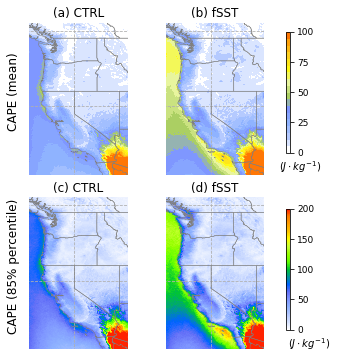

In [9]:
cmap1 = generate_NCL_cmap('perc2_9lev', white_first=True, cont_opt=True, cont_param_n=2)
cmap2 = generate_NCL_cmap('precip3_16lev', reverse_cmap=False, cont_opt=True)

figname = plotdir + 'fig_S4.CAPE_change.png'

data11 = CAPEmean_HIST
data12 = CAPEmean_fSST
unit1 = r'($J \cdot kg^{-1}$)'
label1 = 'CAPE (mean)'
vmin1 = 0
vmax1 = 100


data21 = CAPEp85_HIST
data22 = CAPEp85_fSST
unit2 = r'($J \cdot kg^{-1}$)'
label2 = 'CAPE (85% percentile)'
vmin2 = 0
vmax2 = 200


fig1 = plt.figure(figsize=(6,6))
ax1 = plt.subplot2grid((17,32), (0,0), rowspan=8, colspan=12, projection=ccrs.PlateCarree())
ax2 = plt.subplot2grid((17,32), (0,13), rowspan=8, colspan=12, projection=ccrs.PlateCarree())
ax4 = plt.subplot2grid((17,32), (9,0), rowspan=8, colspan=12, projection=ccrs.PlateCarree())
ax5 = plt.subplot2grid((17,32), (9,13), rowspan=8, colspan=12, projection=ccrs.PlateCarree())


# set 1
visualize_wUS_map(ax1, wrf_lons, wrf_lats, data11, title=r'(a) CTRL',
                  cmap=cmap1, vmin=vmin1, vmax=vmax1, xlim=[-126,-113], ylim=[31,51],
                  map_bdy=False)
visualize_wUS_map(ax2, wrf_lons, wrf_lats, data12, title=r'(b) fSST',
                  cmap=cmap1, vmin=vmin1, vmax=vmax1, xlim=[-126,-113], ylim=[31,51],
                  map_bdy=False)
ax1.text(-128, 42, label1, ha='center', va='center', rotation=90, size=12)


# colorbar
cbar_ax1 = fig1.add_axes([0.75, 0.58, 0.01, 0.28])
cb1 = matplotlib.colorbar.ColorbarBase(cbar_ax1, cmap=cmap1,
                                       ticks=np.arange(0, 1.00001, 1/4), orientation='vertical')
cb1.set_ticklabels(crt_cbar_labels(vmax1, 4, mode='0ton', decimal_flag=0))
cbar_ax1.tick_params(labelsize=9)
cbar_ax1.text(-1.5, -0.15, unit1, size=10)


# set 2
visualize_wUS_map(ax4, wrf_lons, wrf_lats, data21, title=r'(c) CTRL',
                  cmap=cmap2, vmin=vmin2, vmax=vmax2, xlim=[-126,-113], ylim=[31,51],
                  map_bdy=False)
visualize_wUS_map(ax5, wrf_lons, wrf_lats, data22, title=r'(d) fSST',
                  cmap=cmap2, vmin=vmin2, vmax=vmax2, xlim=[-126,-113], ylim=[31,51],
                  map_bdy=False)
ax4.text(-128, 42, label2, ha='center', va='center', rotation=90, size=12)

cbar_ax3 = fig1.add_axes([0.75, 0.17, 0.01, 0.28])
cb3 = matplotlib.colorbar.ColorbarBase(cbar_ax3, cmap=cmap2,
                                       ticks=np.arange(0, 1.00001, 1/4), orientation='vertical')
cb3.set_ticklabels(crt_cbar_labels(vmax2, 4, mode='0ton', decimal_flag=0))
cbar_ax3.tick_params(labelsize=9)
cbar_ax3.text(0.5, -0.15, unit2, size=10)


#fig1.savefig(figname, dpi=600)

plt.show()
plt.close()
del(fig1)